Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

# Introduction

# Data preparation

## Importing Libraries

In [924]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

## Accessing CSV file

In [925]:
#This is the name of the file path
#file_path = "/datasets/car_data.csv"
file_path = "/Users/tanner/Downloads/car_data.csv"

#This is the csv file that contains all of the information that we will use for this project
rusty_df = pd.read_csv(file_path)

# Cleaning the Data

## Inspecting the CSV file for General Information

In [926]:
#Here is the general info for the file
print(rusty_df.info(), "\n\n", rusty_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [927]:
#Here are the statistical measurements of the data
print(rusty_df.describe())

               Price  RegistrationYear          Power        Mileage  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.

## Overview of Potentially Needed Data Changes

It appears that these are the following columns that could be adjusted or removed:
* DateCrawled --> Change to date time format [][]
* VehicleType --> This column needs imputation [][]
* RegistrationYear --> Check unique values --> Check range of values [][]
* GearBox --> Needs Imputation [][]
* Power --> Check values [][]
* Model --> Needs Imputation [][]
* Mileage --> Check values [][]
* RegistrationMonth --> Do we need this? [][]
* FuelType -> Needs Imputation [][]
* NotReparied --> Needs Imputation [][]
* DateCreated --> Needs Imputation [][]
* NumberOfPictures --> Can drop[][]
* PostalCode --> Likely can drop; don't need as a feature [][]
* LastSeen --> datetime conversion [][]

## Changing Various Columns to DateTime Format

In [928]:
#Here is the first 10 entries of the DateCrawled, DateCreated, and Last seen Columns

#Datecrawled
print(rusty_df['DateCrawled'].head(5))

#DateCreated
print(rusty_df['DateCreated'].head(5))

#LastSeen
print(rusty_df['LastSeen'].head(5))

0    24/03/2016 11:52
1    24/03/2016 10:58
2    14/03/2016 12:52
3    17/03/2016 16:54
4    31/03/2016 17:25
Name: DateCrawled, dtype: object
0    24/03/2016 00:00
1    24/03/2016 00:00
2    14/03/2016 00:00
3    17/03/2016 00:00
4    31/03/2016 00:00
Name: DateCreated, dtype: object
0    07/04/2016 03:16
1    07/04/2016 01:46
2    05/04/2016 12:47
3    17/03/2016 17:40
4    06/04/2016 10:17
Name: LastSeen, dtype: object


We need to convert these columns into datetime format.

In [929]:
"""
Here we convert the aformentioned columns to datetime format, and the month will be displayed first in our datetime
objects since that is the standard description of a date in the US.
"""

#Here we convert the DateCrawled column to datetime format
rusty_df['DateCrawled'] = pd.to_datetime(rusty_df['DateCrawled'], errors = 'coerce', dayfirst = True)

#Here we convert the DateCreated column to datetime format
rusty_df['DateCreated'] = pd.to_datetime(rusty_df['DateCreated'], errors='coerce', dayfirst = True)

#Here we convert the LastSeen column to datetime format
rusty_df['LastSeen'] = pd.to_datetime(rusty_df['LastSeen'], errors='coerce', dayfirst=True)

Let's check to see if the changes were made

In [930]:
#Check to see if DateCrawled, DateCreated, and LastSeen were converted to datetime format correctly
print(rusty_df[['DateCrawled', 'DateCreated', 'LastSeen']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   DateCrawled  354369 non-null  datetime64[ns]
 1   DateCreated  354369 non-null  datetime64[ns]
 2   LastSeen     354369 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 8.1 MB
None


## Checking the Years for Registration Year of Vehicle

Here are the first few entries of our RegistrationYear feature.

In [931]:
print(rusty_df['RegistrationYear'].head(10))

0    1993
1    2011
2    2004
3    2001
4    2008
5    1995
6    2004
7    1980
8    2014
9    1998
Name: RegistrationYear, dtype: int64


Let's see all of the unique registration year values we have in our dataset—-assuming it is not too large.

In [932]:
#Printing the unique registration years from earliest to latest
print(rusty_df['RegistrationYear'].sort_values(ascending=False).unique())

[9999 9996 9450 9229 9000 8888 8500 8455 8200 8000 7800 7500 7100 7000
 6500 6000 5911 5900 5600 5555 5300 5000 4800 4500 4100 4000 3800 3700
 3500 3200 3000 2900 2800 2500 2290 2222 2200 2066 2019 2018 2017 2016
 2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003 2002
 2001 2000 1999 1998 1997 1996 1995 1994 1993 1992 1991 1990 1989 1988
 1987 1986 1985 1984 1983 1982 1981 1980 1979 1978 1977 1976 1975 1974
 1973 1972 1971 1970 1969 1968 1967 1966 1965 1964 1963 1962 1961 1960
 1959 1958 1957 1956 1955 1954 1953 1952 1951 1950 1949 1948 1947 1946
 1945 1944 1943 1942 1941 1940 1938 1937 1936 1935 1934 1933 1932 1931
 1930 1929 1928 1927 1925 1923 1920 1919 1915 1910 1800 1688 1602 1600
 1500 1400 1300 1255 1253 1234 1200 1111 1039 1001 1000]


There are a few reasons why many of these values will serve as neither good training nor testing data. First, we have recorded time periods where automobiles did not exist, e.g., 1000 AD. Secondly, we have particular years that have not occured yet; for example, the year 9999 AD is past the current year by several millenia. Therefore, we are going to have to remove the rows that do not fit well for our model. In addition to our filtering, classic cars (for this project, cars registered by 1990) will also be removed. Classic cars are often priced differently than typical newer cars in today's time. Therefore, to achieve better pricing predictions for relatively modern cars with standard pricing methods, we will filter our classic cars.

In [933]:
#We are going to keep cars that were registered between 1990 and 2019
rusty_df = rusty_df[(rusty_df['RegistrationYear'] >= 1990) & (rusty_df['RegistrationYear'] <= 2019)].reset_index(drop = True)

Let's check to see if the changes were made.

In [934]:
print(rusty_df['RegistrationYear'].sort_values(ascending=False).unique())

[2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009 2008 2007 2006
 2005 2004 2003 2002 2001 2000 1999 1998 1997 1996 1995 1994 1993 1992
 1991 1990]


## Inspecting Power Values

Let's see the general statistics for the power feature in our data.

In [935]:
print(rusty_df['Power'].describe())

count    344595.000000
mean        110.805772
std         187.221179
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


There are values of horsepower (HP) that are not realistic values. Observing the max value of 20000 and a minimum value of 0, these are likely typos, glitches, missign entries, or something related. 300 HP for a car is a high value compared to most everyday cars. Moreover, in terms of sports cars, values can range from 300 - 600 on average. Let's set the maximum HP to 600 for our power feature.

In [936]:
#Here we filter out any row from our dataframe that has a horsepower of anything strictly larger than 600
rusty_df = rusty_df[rusty_df['Power'] <= 600].reset_index(drop = True)

#Let us observe the general statistics now
print(rusty_df['Power'].describe())

count    344235.000000
mean        107.285686
std          63.081177
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max         600.000000
Name: Power, dtype: float64


We lost a fraction of our data after the removal of any row with horsepower greater than 600. Our mean dropped by 4 points roughly and our standard deviation improved considerably. However, we still have a minimum value of 0. Before we observe the distribution of the power feature, let's see the frequency of the of our top values to get a numerical sense of what is going on.

In [937]:
print(rusty_df['Power'].value_counts().head())

Power
0      37768
75     23660
60     15660
150    14491
101    13236
Name: count, dtype: int64


Clearly we have multiple data points whose horsepower is zero. Removing the rows with this HP would remove more data than ideal so we need to impute the data with a central tendency, likely the mean or medium. Let's take a look at the distribution to see if we should impute the column with.

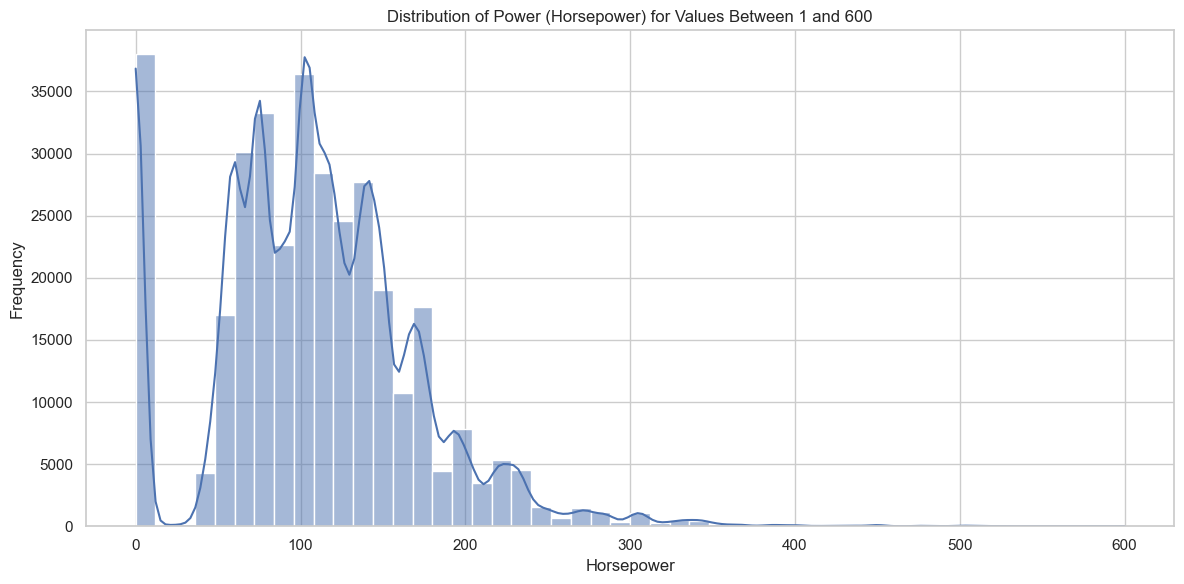

In [938]:
#Setting up the plot
plt.figure(figsize=(12, 6))
sns.histplot(rusty_df['Power'], bins=50, kde=True)
plt.title('Distribution of Power (Horsepower) for Values Between 1 and 600')
plt.xlabel('Horsepower')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

There are outliers for this particular distribution, which could disrupt the positioning of the mean. To see the best choice for imputation, we will replace the 0's of our power feature with both the mean and median of our distribution and see which distribution gives better statistics.

In [939]:
#First, let us replace all of the zeros with null values; we can do this since there are no null values within this column
rusty_df['Power'].replace(0, np.nan, inplace = True)

#Now we can replace all of our null values with the mean and median. We'll be sure to make copies of the dataframe beforehand

#Making copies of the dataframe
mean_df = rusty_df.copy(deep = True)
median_df = rusty_df.copy(deep = True)

#Imputing null values with mean and median
mean_df['Power'] = mean_df['Power'].fillna(mean_df['Power'].mean())
median_df['Power'] = median_df['Power'].fillna(median_df['Power'].median())

#Now let's see some of the stats for these copies
print(mean_df['Power'].describe())
print(median_df['Power'].describe())

count    344235.000000
mean        120.507226
std          50.603841
min           1.000000
25%          84.000000
50%         118.000000
75%         143.000000
max         600.000000
Name: Power, dtype: float64
count    344235.000000
mean        119.354418
std          50.710281
min           1.000000
25%          84.000000
50%         110.000000
75%         143.000000
max         600.000000
Name: Power, dtype: float64


/var/folders/s0/ttxls7cd5w1g444b5l_mfp1c0000gp/T/ipykernel_32357/1513582792.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rusty_df['Power'].replace(0, np.nan, inplace = True)


Regardless of whether the data is imputed by the mean or median, the values are roughly the same, even for the mean itself. Thus, choosing either value to use is fine. We'll inspect the distributions just for context to be sure.

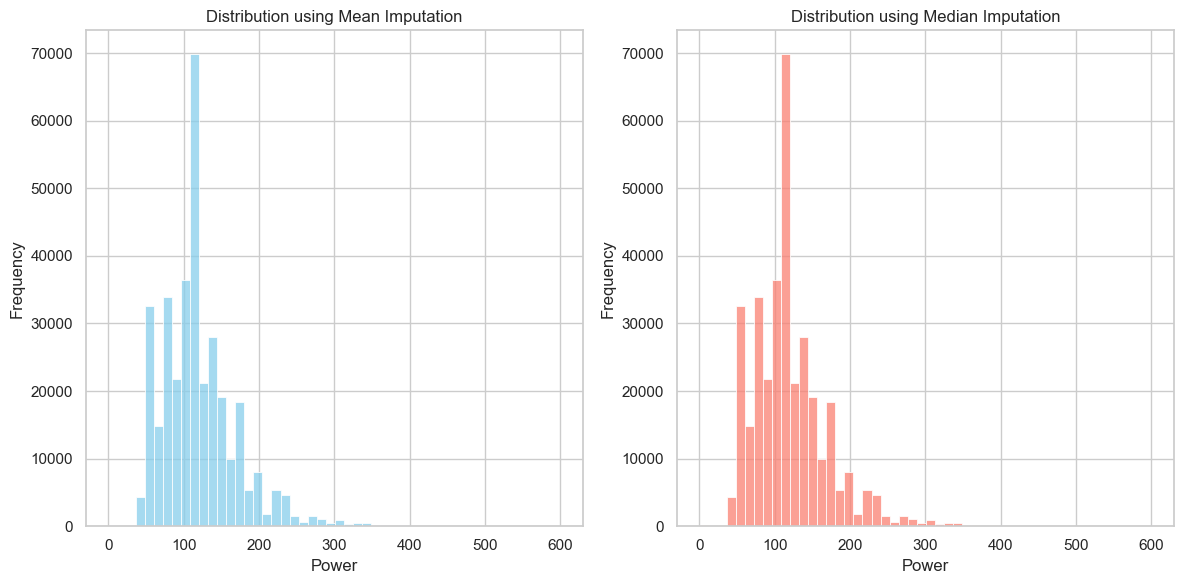

In [940]:
#Setting up the plot figure
plt.figure(figsize=(12, 6))

#Plotting the mean-imputed data
plt.subplot(1,2,1)
sns.histplot(mean_df['Power'], bins = 50, color='skyblue')
plt.title('Distribution using Mean Imputation')
plt.xlabel('Power')
plt.ylabel('Frequency')

#Plotting the median-imputted data
plt.subplot(1,2,2)
sns.histplot(median_df['Power'], bins=50, color='salmon')
plt.title('Distribution using Median Imputation')
plt.xlabel("Power")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Since the distributions are virtually the same, imputing the power column with the mean is sufficient.

In [941]:
#Let's check to ensure that the indices of the origial dataframe and the mean imputed dataframe have the same index
(rusty_df.index == mean_df.index).all()

np.True_

In [942]:
#Now let's replace the original dataframe power feature with the feature of the imputed data
rusty_df['Power'] = mean_df['Power']

Let's check the statistics of the power column just to be sure the changes were made.

In [943]:
print(rusty_df['Power'].describe())

count    344235.000000
mean        120.507226
std          50.603841
min           1.000000
25%          84.000000
50%         118.000000
75%         143.000000
max         600.000000
Name: Power, dtype: float64


## Replacing Categorical Features with Mode

Here are the first few entries of our categorical feature that we are likely going to use with our model later.

In [944]:
#A list of our categorical columns
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']

print(rusty_df[categorical_features].head(5))

  VehicleType Gearbox  Model  FuelType NotRepaired
0         NaN  manual   golf    petrol         NaN
1       coupe  manual    NaN  gasoline         yes
2         suv    auto  grand  gasoline         NaN
3       small  manual   golf    petrol          no
4       small  manual  fabia  gasoline          no


Let's check to see the number of duplicates that are in these columns.

In [945]:
print(rusty_df[categorical_features].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344235 entries, 0 to 344234
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   VehicleType  307972 non-null  object
 1   Gearbox      325999 non-null  object
 2   Model        326242 non-null  object
 3   FuelType     313178 non-null  object
 4   NotRepaired  276397 non-null  object
dtypes: object(5)
memory usage: 13.1+ MB
None


Since we are working with categorical columns that contain thousands of null entries, we need to impute them with their corresponding modes.

In [946]:
#This for loop will impute the mode for the null values in each respective feature
for feature in categorical_features:
    if rusty_df[feature].isnull().sum() > 0:
        mode_value = rusty_df[feature].mode()[0]
        rusty_df[feature].fillna(mode_value, inplace = True)

/var/folders/s0/ttxls7cd5w1g444b5l_mfp1c0000gp/T/ipykernel_32357/2312664234.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rusty_df[feature].fillna(mode_value, inplace = True)


Let's check to ensure that there we have only valid entries in our categorical columns.

In [947]:
print(rusty_df[categorical_features].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344235 entries, 0 to 344234
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   VehicleType  344235 non-null  object
 1   Gearbox      344235 non-null  object
 2   Model        344235 non-null  object
 3   FuelType     344235 non-null  object
 4   NotRepaired  344235 non-null  object
dtypes: object(5)
memory usage: 13.1+ MB
None


## Checking Registration Month Featue

Let's check the first few entire of our registration month column.

In [948]:
print(rusty_df['RegistrationMonth'].head(10))

0     0
1     5
2     8
3     6
4     7
5    10
6     8
7     8
8     0
9    12
Name: RegistrationMonth, dtype: int64


Though registration year could certainly the pricing of a car, the month may not have as great of an impact. Let's check to see the correlation between the month feature and the pricing of a car. If the correlation is low, we will drop this column and not use it as a feature.

In [949]:
#Since the many missing entries '0', we need to replace those with null values and drop them to find the pearson correlation

#Make a copy of our dataframe for testing
correlation_test_df = rusty_df.copy()

#Replacing the 0's with null values
correlation_test_df['RegistrationMonth'] = correlation_test_df['RegistrationMonth'].astype('Int64').replace(0, pd.NA)

#Calculating the correlation between registration month and vehicle pricing; we drop any row that contains a null registration month for more accurate results
correlation = correlation_test_df[['RegistrationMonth', 'Price']].dropna().corr().loc['RegistrationMonth', 'Price']

#Result
correlation

np.float64(0.013931835441271011)

We see that there is a weak positive correlation between registration month of a car and it's value. Let's check take a look at the distribution.

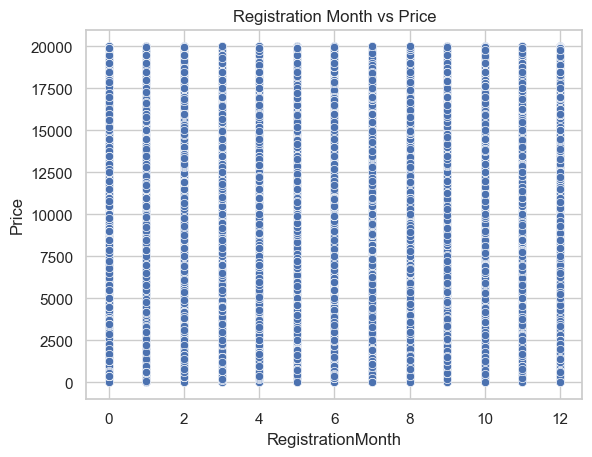

In [950]:
#Scatterplot to see what visual correlation is between registration month and price
sns.scatterplot(data=rusty_df, x = 'RegistrationMonth', y = 'Price')
plt.title('Registration Month vs Price')
plt.show()

Clearly, there is not a discernable pattern here. This is likely due to the fact that this is a categorical column and there are many values per category. Let's visualize the distribution using a boxplot for each category. This may help to see a particular pattern.

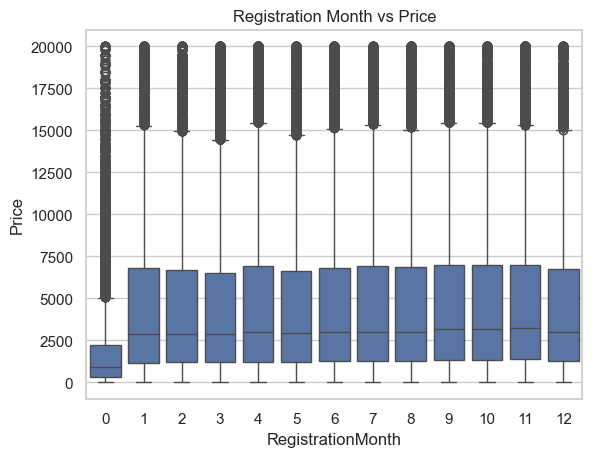

In [951]:
sns.boxplot(data=rusty_df, x='RegistrationMonth', y='Price')
plt.title('Registration Month vs Price')
plt.show()

Once again, there's no discernable correlation between registration month and target. They all have relatively similar quartiles and medians, as well a, similar clusters of outliers. We do have a column of 'month 0', which is likely a typo or a placeholder for null values. Imputing these this categoriy with the mode would likely not change anything--except for the mode itself. Therefore, we can safely drop this column so that we do not use it as a feature in the training and testing of our models.

In [952]:
rusty_df = rusty_df.drop(columns=['RegistrationMonth'])

Let's check to ensure that the RegistrationMonth columns was dropped.

In [953]:
print(rusty_df.columns)

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Mileage', 'FuelType', 'Brand', 'NotRepaired',
       'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'],
      dtype='object')


## Checking Mileage Values

Let's check the first few values in our Mileage column.

In [954]:
print(rusty_df['Mileage'].head(10))

0    150000
1    125000
2    125000
3    150000
4     90000
5    150000
6    150000
7     30000
8    150000
9    150000
Name: Mileage, dtype: int64


Mileage is often a significant factor in the value of the car. Typically, as a car gradually increases in mileage, its overall value begins to decrease. Let's see if there is a linear correlation, for this dataframe, between the mileage and pricing of a car.

In [955]:
rusty_df[['Mileage', 'Price']].corr().loc['Mileage', 'Price']

np.float64(-0.3457514838938965)

We have a moderate negative correlation (higher mileage means lower price), which is what we expected. Let's see what the unique values of mileage are.

In [956]:
print(rusty_df['Mileage'].value_counts(dropna=False))

Mileage
150000    233361
125000     35622
100000     14095
90000      11163
80000       9629
70000       8231
60000       7111
50000       5938
5000        5408
40000       4679
30000       4218
20000       3753
10000       1027
Name: count, dtype: int64


It appears that mileage recordings are rounded off. Moreover, due to the large frequency of cars with 150000 miles, this is likely a mileage cap that Rusty Bargain implemented. We do not need to change the values in this column. However, the distribution may be skewed to the right to the point where we need to do a log transformation. Let's take a look.

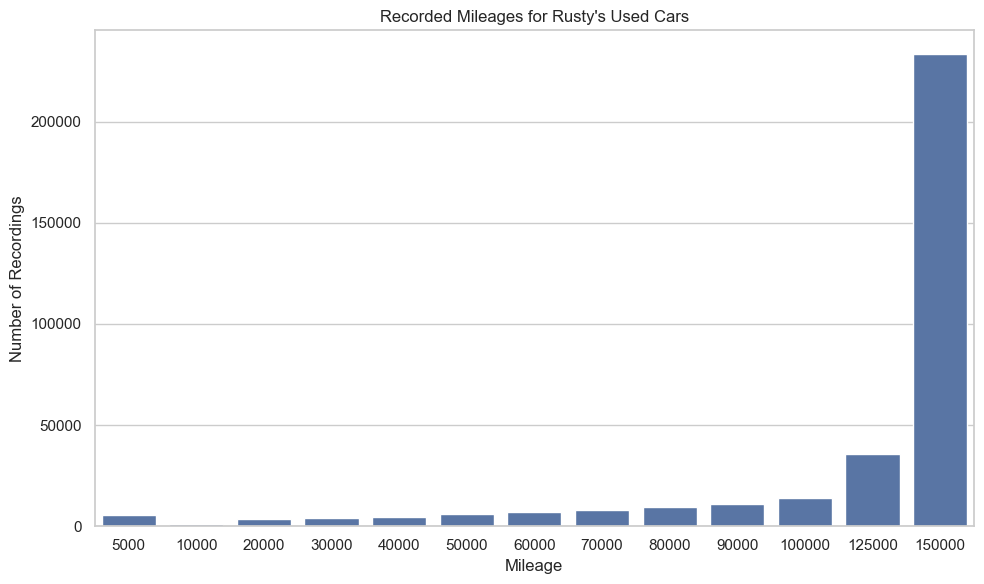

In [957]:
#Setting the background
sns.set(style='whitegrid')

#Establishing the figure
plt.figure(figsize=(10,6))
sns.countplot(x='Mileage', data=rusty_df)

#Adding labels
plt.xlabel("Mileage")
plt.ylabel("Number of Recordings")
plt.title("Recorded Mileages for Rusty's Used Cars")
plt.tight_layout()
plt.show()

In [958]:
#Skewness of distribution
print(rusty_df['Mileage'].skew())

-1.7567982778357263


We clearly see that the distribution is left-skewed so there's no need for a log transformation. The skewness is calculated as -1.72, which is demonstrated by our graph. There's nothing to impute so our feature will remain the same unless we scale it later, which could be important for linear regression.

## Checking Target Values

Let's check the first few entries of our target columns (Price).

In [959]:
#First few entires of the price column
print(rusty_df['Price'].head(10))

0      480
1    18300
2     9800
3     1500
4     3600
5      650
6     2200
7    14500
8      999
9     2000
Name: Price, dtype: int64


Let's see the general statistics for this column.

In [960]:
#General statistics for our target
print(rusty_df['Price'].describe())

count    344235.000000
mean       4408.633683
std        4504.013690
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6396.500000
max       20000.000000
Name: Price, dtype: float64


We see that the minimum price of cars is 0, which is likely a typo or some kind of null entry. It would be ideal to filter the price of vehicles to something more realistic, 100 for example. We will check the sum of relative frequencies of prices from 0 - 99 to ensure we do not lose too much data. In addition, the price column has a mean of 4408 and a median of 2700, indicating that we have heavy outliers that are pulling the mean to be bigger than the median. This suggests that our distirbution is skewed right. The spread of this data is also considerable because our standard deviation is 4504. 

Let's check the sum of relative frequences of prices ranging from 0 - 99 so that we may know if it is safe to remove rows in our dataframe that contain any of these prices.

In [961]:
#This is the number of entries in our Price column
price_entries = len(rusty_df['Price'])

#Here is a filtered version of our rusty_df dataframe that only contains the rows which contain prices ranging from 0 - 99.
filtered_prices_df= rusty_df[(rusty_df['Price'] >= 0) & (rusty_df['Price'] < 100)]

#This is the number of rows that our filtered dataframe contains. This is used to calculate the relative frequency.
number_rows_filtered_prices = filtered_prices_df.shape[0]

#Relative frequency calculation
relative_frequency = number_rows_filtered_prices / price_entries

#Result
print(relative_frequency)

0.03578659927084695


The prices ranging from 0 - 99 only compromise of roughly 4% of the data. Therefore, we are going to filter out these prices values so that we get an accurate depiction of our distribution when we graph it.

In [962]:
#Here we filter out the dataframe by have price 100 or more
reasonable_price = rusty_df[rusty_df['Price'] >= 100]

Let's ensure that changes took place and then we can visualize our distribution.

In [963]:
print(reasonable_price['Price'].describe())

count    331916.000000
mean       4572.055788
std        4504.749082
min         100.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64


Let's take a look at the distribution of values in this target and calculate skewness.

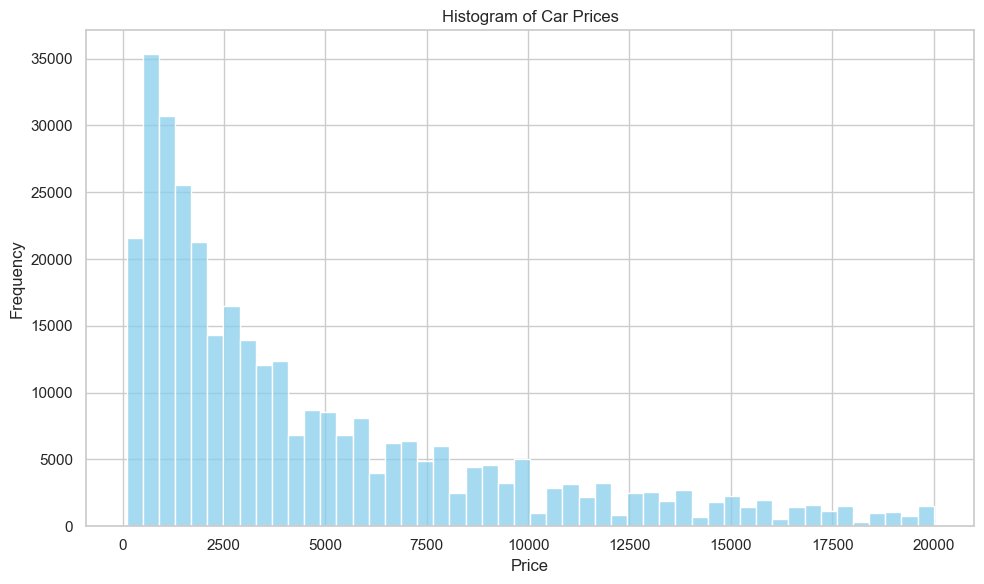

In [964]:
plt.figure(figsize=(10,6))
sns.histplot(data=reasonable_price, x='Price', bins=50, kde=False, color='skyblue')

plt.title('Histogram of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [965]:
print(reasonable_price['Price'].skew())

1.4123840032192767


Since our distribution has a skewness of 1.41 and our graph is visually skewed to the right, a log transformation will be implemented since we are using linear regression in our models later on. This helps with the normality assumption with linear regression.

In [966]:
#Here we filter the original dataframe to contain the appropriate price values
rusty_df = rusty_df[rusty_df['Price'] >= 100]

#Log transformation of our prices
rusty_df['LogPrice'] = np.log(rusty_df['Price'])

Now let's compare the distibutions visually and calculate the skewness of the log distribution.

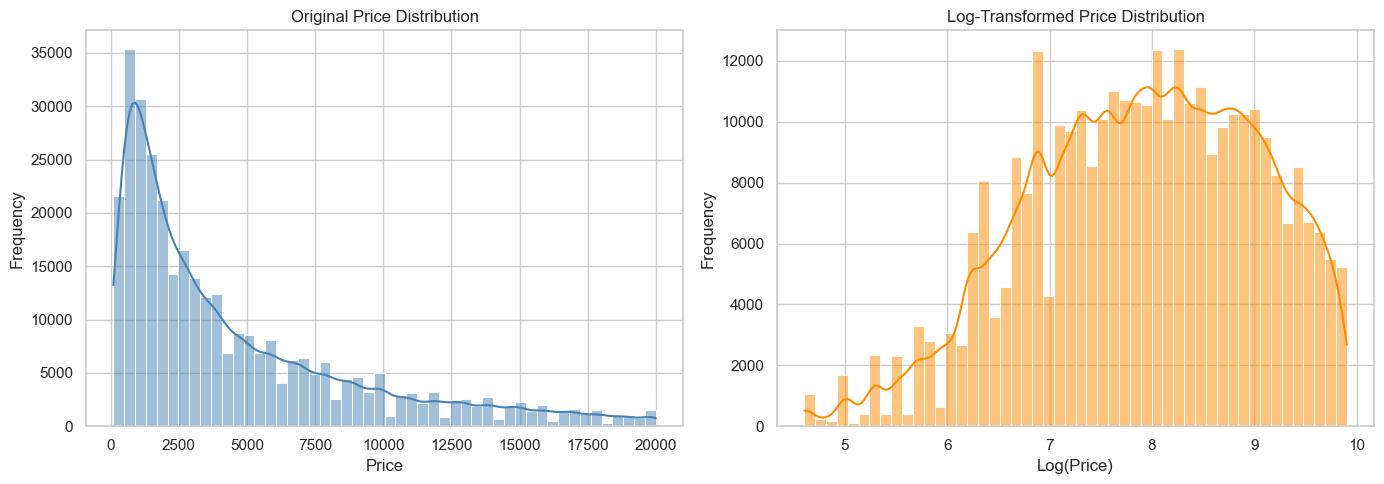

In [967]:
plt.figure(figsize=(14, 5))

# Original Price Distribution
plt.subplot(1, 2, 1)
sns.histplot(data=rusty_df, x='Price', bins=50, kde=True, color='steelblue')
plt.title('Original Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Log-Transformed Price Distribution
plt.subplot(1, 2, 2)
sns.histplot(data=rusty_df, x='LogPrice', bins=50, kde=True, color='darkorange')
plt.title('Log-Transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [975]:
#Skewness of log prices
print(rusty_df['LogPrice'].skew())

-0.3255772481732026


## Checking Duplicate Rows in Entire Dataframe

Up to this point, we have inspected each column individually for null values / invalid data entries, which were handled using removal of data or imputation. Now we need to check to see if there are any duplicated rows in entire dataframe because there should not be any. If there are, we will remove them.

In [968]:
#Here are the number of duplicated rows we have in our dataframe. This will be used for boolean indexing next
duplicated_rows = rusty_df.duplicated().sum()

#Here we see the first few duplicated rows, if there are any
rusty_df[rusty_df.duplicated()].head(15) if duplicated_rows > 0 else None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,LogPrice
13904,2016-03-21 19:06:00,5999,small,2009,manual,80.0,polo,125000,petrol,volkswagen,no,2016-03-21,0,65529,2016-04-05 20:47:00,8.699348
26808,2016-03-23 10:38:00,12200,bus,2011,manual,125.0,zafira,40000,gasoline,opel,no,2016-03-23,0,26629,2016-04-05 07:44:00,9.409191
30730,2016-04-03 20:41:00,4950,wagon,2003,auto,170.0,e_klasse,150000,gasoline,mercedes_benz,no,2016-04-03,0,48432,2016-04-05 21:17:00,8.507143
32211,2016-03-07 20:45:00,10900,convertible,2005,auto,163.0,clk,125000,petrol,mercedes_benz,no,2016-03-07,0,61200,2016-03-21 03:45:00,9.296518
42408,2016-03-13 20:48:00,4200,sedan,2003,manual,105.0,golf,150000,gasoline,volkswagen,no,2016-03-13,0,14482,2016-03-13 20:48:00,8.342840
46102,2016-03-07 19:42:00,370,sedan,1997,manual,75.0,megane,150000,petrol,renault,no,2016-03-07,0,38179,2016-03-12 17:47:00,5.913503
47834,2016-03-13 11:38:00,11499,wagon,2011,manual,105.0,passat,125000,gasoline,volkswagen,no,2016-03-13,0,50354,2016-03-13 11:38:00,9.350015
48394,2016-03-16 10:06:00,4200,small,2007,manual,133.0,yaris,150000,petrol,toyota,no,2016-03-16,0,55469,2016-03-16 23:21:00,8.342840
51624,2016-03-27 11:58:00,8290,convertible,2000,auto,218.0,slk,150000,petrol,mercedes_benz,no,2016-03-27,0,79206,2016-04-01 11:18:00,9.022805
51817,2016-03-05 14:12:00,2689,small,2005,auto,61.0,fortwo,90000,petrol,smart,no,2016-03-03,0,56412,2016-04-05 04:49:00,7.896925


Clearly we have several duplicates that need to be dropped. Of course the first instances will be kept, but any copies will be deleted.

In [969]:
#Here we drop the duplicates in our rust_df dataframe
rusty_df.drop_duplicates(inplace = True)

In [970]:
print(rusty_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 331614 entries, 0 to 344234
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DateCrawled       331614 non-null  datetime64[ns]
 1   Price             331614 non-null  int64         
 2   VehicleType       331614 non-null  object        
 3   RegistrationYear  331614 non-null  int64         
 4   Gearbox           331614 non-null  object        
 5   Power             331614 non-null  float64       
 6   Model             331614 non-null  object        
 7   Mileage           331614 non-null  int64         
 8   FuelType          331614 non-null  object        
 9   Brand             331614 non-null  object        
 10  NotRepaired       331614 non-null  object        
 11  DateCreated       331614 non-null  datetime64[ns]
 12  NumberOfPictures  331614 non-null  int64         
 13  PostalCode        331614 non-null  int64         
 14  LastSeen 

## Checking Duplicate Values in Each Column

Below is a listing of the columns in our dataframe with the number of duplicates contained within the columns, as well as, their corresponding relative frequencies. For most of the columns, duplciates are appropriate. However, any columns that are not will be investigated closer.

In [971]:
#Number of rows in the dataframe --> used to calculate relative frequency of duplicates in each column
num_rows = len(rusty_df)

#This is the list of columns in our dataframe
rusty_columns = rusty_df.columns

#This for loop iterates over every columns and displays the column name, number of duplicates, and the relative frequency of duplicates in the respective column
for column in rusty_columns:
    #Number of duplicates in each column
    num_duplicates = rusty_df[column].duplicated().sum()

    #Relative frquency of duplicates in each column
    relative_freq = (num_duplicates / num_rows) * 100

    #Output
    print(f'Column: {column}')
    print(f'Duplicates: {num_duplicates}')
    print(f'Relative frequency: {relative_freq:.2f} % \n')




Column: DateCrawled
Duplicates: 316300
Relative frequency: 95.38 % 

Column: Price
Duplicates: 327985
Relative frequency: 98.91 % 

Column: VehicleType
Duplicates: 331606
Relative frequency: 100.00 % 

Column: RegistrationYear
Duplicates: 331584
Relative frequency: 99.99 % 

Column: Gearbox
Duplicates: 331612
Relative frequency: 100.00 % 

Column: Power
Duplicates: 331181
Relative frequency: 99.87 % 

Column: Model
Duplicates: 331366
Relative frequency: 99.93 % 

Column: Mileage
Duplicates: 331601
Relative frequency: 100.00 % 

Column: FuelType
Duplicates: 331607
Relative frequency: 100.00 % 

Column: Brand
Duplicates: 331574
Relative frequency: 99.99 % 

Column: NotRepaired
Duplicates: 331612
Relative frequency: 100.00 % 

Column: DateCreated
Duplicates: 331505
Relative frequency: 99.97 % 

Column: NumberOfPictures
Duplicates: 331613
Relative frequency: 100.00 % 

Column: PostalCode
Duplicates: 323481
Relative frequency: 97.55 % 

Column: LastSeen
Duplicates: 313319
Relative frequency

# Exploratory Data Analysis

# Model training

## Dropping Columns that Will Not be Used as Features

As mentioned in our "checklist" of things to do to improve our data, we do not need particular columns when training our model. Those columns are the 'PostalCode' and 'Number of Pictures' column. These do not pertain to the value of a car; therefore, we will not need them in the training of our model, which is to predict prices.

In [972]:
#Here we drop the unnecessary columns
rusty_df.drop(columns=['NumberOfPictures', 'PostalCode'], inplace = True)

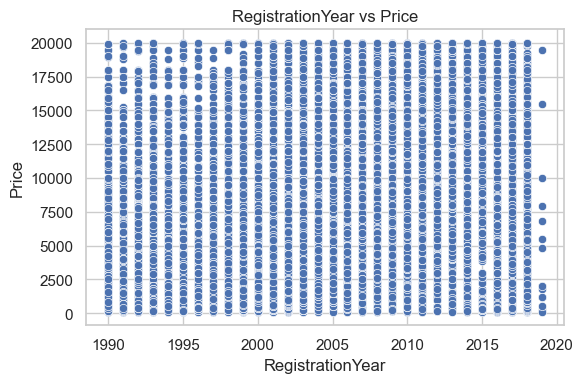

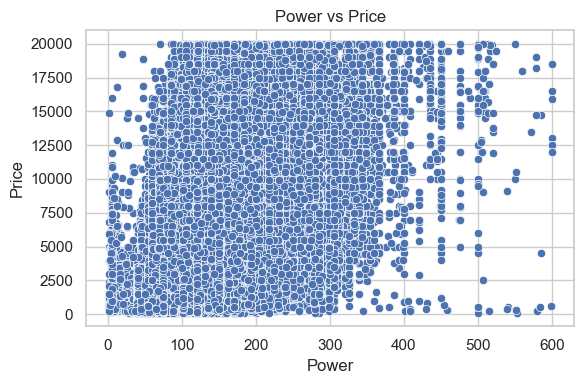

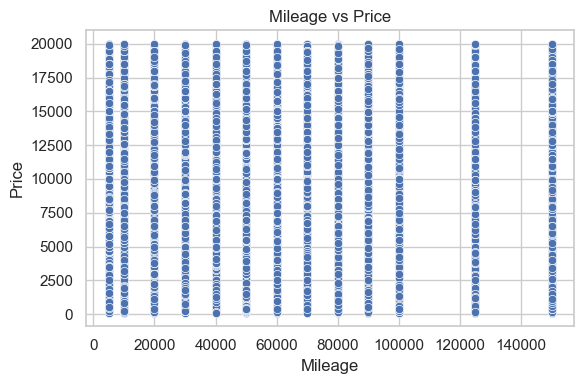

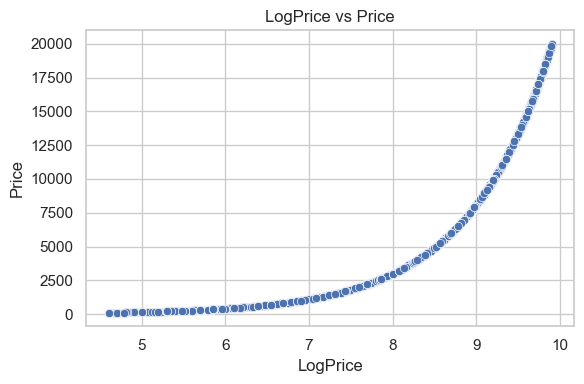

In [973]:
target = 'Price'

numeric_features = rusty_df.select_dtypes(include='number').drop(columns=[target])

for feature in numeric_features.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=feature, y = target, data=rusty_df)
    plt.title(f'{feature} vs {target}')
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()


# Model analysis

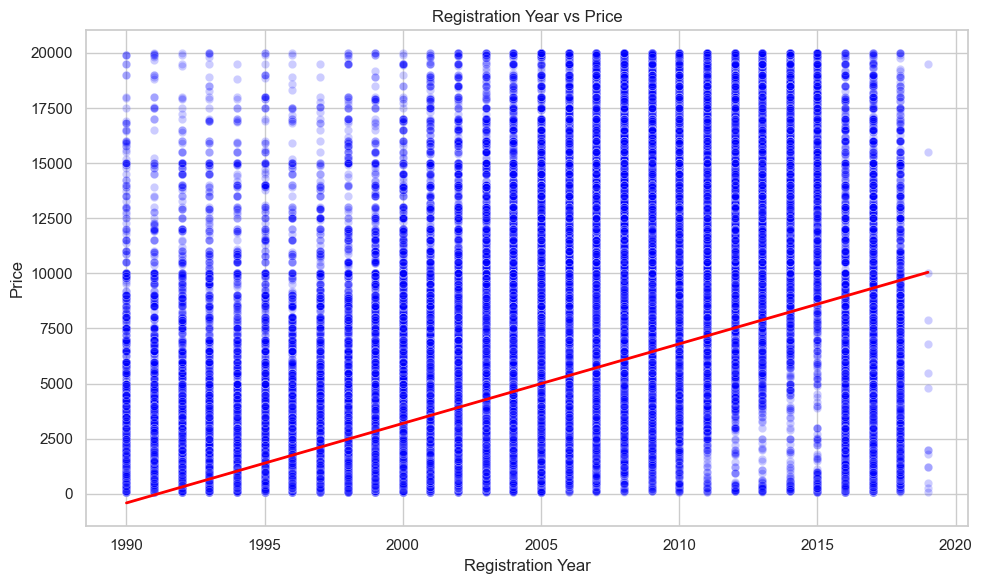

In [974]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Transparent scatter plot
sns.scatterplot(
    x='RegistrationYear',
    y='Price',
    data=rusty_df,
    alpha=0.2,
    color='blue'
)

# Overlay regression line
sns.regplot(
    x='RegistrationYear',
    y='Price',
    data=rusty_df,
    scatter=False,
    color='red',
    line_kws={'linewidth': 2}
)

plt.title('Registration Year vs Price')
plt.xlabel('Registration Year')
plt.ylabel('Price')
plt.tight_layout()
plt.show()


# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed